In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
name_mapper = {'SVR': 'SVM', 
               'RandomForestRegressor': 'RF', 
               'AdaBoostRegressor': 'AdaBoost', 
               'GradientBoostingRegressor': 'GradientBoosting', 
               'BaggingRegressor': 'Bagging',
               'MLPRegressor': 'MLP (Neural Net)',
               'Euclidean Distance': 'Euclidean',
               'Pearson Correlation': 'Pearson',
               'Jaccard Index': 'Jaccard'
              }

In [3]:
styles = {'SVM': ['red', 'o', (0, (1, 1))], 'BayesianRidge': ['green', 'v', (0, (1, 1))], 
          'Lasso': ['blue', 'p', (0, (1, 1))], 'Ridge': ['cyan', 's', (0, (5, 10))], 
          'Bagging': ['orange', 'D', (0, (5, 5))], 'AdaBoost': ['violet', 'x', (0, (5, 1))], 
          'RF': ['magenta', 'd', (0, (3, 10, 1, 10))], 'GradientBoosting': ['olive', '8', (0, (3, 5, 1, 5))], 
          'MLP (Neural Net)': ['brown', '*', (0, (5, 1))],
          'Euclidean Distance (user-based)': ['yellow', 'H', (0, (3, 1, 1, 1))], 
          'Euclidean Distance (item-based)': ['black', '<', (0, (3, 5, 1, 5, 1, 5))], 
          'Pearson Correlation (user-based)': ['gray', '>', (0, (3, 10, 1, 10, 1, 10))], 
          'Pearson Correlation (item-based)': ['teal', '^', (0, (3, 1, 1, 1, 1, 1))], 
          'Jaccard Index (user-based)': ['lawngreen', 'P', 'solid'], 
          'Jaccard Index (item-based)': ['deeppink', '*', 'dashdot'],
          'Euclidean': ['#1f77b4', 'o', '-'],  
          'Jaccard':      ['#2ca02c', 's', '--'], 
          'Pearson':['#d62728', '^', '-.']}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_cluster_group(
    data_dict,
    title_suffix,
    name_mapper,
    styles,
    stats_data,
    tag
):
    fig, axs = plt.subplots(2, 1, figsize=(5.5, 6.5), sharex=True)

    for model in data_dict:
        cluster_counts = sorted(data_dict[model].keys())

        means_rmse, sems_rmse = [], []
        means_mae,  sems_mae  = [], []

        for num_cluster in cluster_counts:
            temp_rmse, temp_mae = [], []

            for n_training_sem in data_dict[model][num_cluster]:
                y_true = data_dict[model][num_cluster][n_training_sem]['y_true']
                y_pred = data_dict[model][num_cluster][n_training_sem]['y_pred']

                temp_rmse.append(np.sqrt(mean_squared_error(y_true, y_pred)))
                temp_mae.append(mean_absolute_error(y_true, y_pred))

            # --- stats data (for tests later) ---
            stats_key = f"{model}_{tag}_k{num_cluster}"
            stats_data[stats_key] = {
                'rmse': temp_rmse,
                'mae': temp_mae
            }

            # --- mean ± SEM ---
            means_rmse.append(np.mean(temp_rmse))
            means_mae.append(np.mean(temp_mae))

            sems_rmse.append(np.std(temp_rmse, ddof=1) / np.sqrt(len(temp_rmse)))
            sems_mae.append(np.std(temp_mae,  ddof=1) / np.sqrt(len(temp_mae)))

        lbl = name_mapper.get(model, model)
        style_key = name_mapper.get(model, model) 
        style = styles.get(style_key, ['black', 'o', '-'])


        x = np.arange(len(cluster_counts))

        axs[0].errorbar(
            x, means_rmse, yerr=sems_rmse,
            label=lbl,
            color=style[0],
            marker=style[1],
            linestyle=style[2],
            linewidth=1.2,
            ms=2.5,
            capsize=2,
            elinewidth=0.9,
            alpha=0.8
        )


        axs[1].errorbar(
            x, means_mae, yerr=sems_mae,
            label=lbl,
            color=style[0],
            marker=style[1],
            linestyle=style[2],
            linewidth=1.2,
            ms=2.5,
            capsize=2,
            elinewidth=0.9,
            alpha=0.8
        )


    # --- axes styling ---
    axs[0].set_ylabel("RMSE", fontfamily='serif', fontsize=11)
    axs[1].set_ylabel("MAE",  fontfamily='serif', fontsize=11)
    axs[1].set_xlabel("Number of Clusters (k)", fontfamily='serif', fontsize=11)

    axs[1].set_xticks(np.arange(len(cluster_counts)))
    axs[1].set_xticklabels([f"k={k}" for k in cluster_counts],
                           fontfamily='serif', fontsize=11)

    for ax in axs:
        ax.grid(axis='y')
        ax.tick_params(axis="both", which="both", length=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    axs[0].set_title(title_suffix, fontfamily='serif', fontsize=12)
    axs[1].legend(
        prop={'family': 'serif', 'size': 10},
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )


    plt.tight_layout()
    return fig

In [5]:
def split_dict(d, n_parts):
    items = list(d.items())
    return [
        dict(items[i::n_parts])
        for i in range(n_parts)
    ]

### Baseline:

In [6]:
with open('../results/baseline_regression_results.json') as fr:
    baseline_reg = json.load(fr)    

In [7]:
with open('../results/baseline_collaborative_filtering_results (user-based).json') as fr:
    baseline_cb_user = json.load(fr)    

In [8]:
with open('../results/baseline_collaborative_filtering_results (item-based).json') as fr:
    baseline_cb_item = json.load(fr)    

In [11]:
# ayri cizim fonksiyonu 
def plot_baseline_separate(reg, cb_user, cb_item, metric='rmse', suffix=''):
    """
    metric: 'rmse' veya 'mae'
    Y eksenini veriye göre otomatik (dinamik) ayarlar.
    """
    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
    
    # Tüm değerleri burada toplayacağız (Min/Max hesabı için)
    all_values = []

    # --- 1. REGRESYON MODELLERİ ---
    for model in reg:
        error_list = []
        # Bazı modellerde her dönem olmayabilir, kontrol ederek alalım
        sorted_sems = sorted(reg[model].keys())
        
        # X ekseni (Dönem sayısı)
        x_axis = np.arange(len(sorted_sems))
        
        for n_training_sem in sorted_sems:
            val = reg[model][n_training_sem][metric][1] # Index 1: Test Hatası
            error_list.append(val)
        
        # Listeyi genel havuza ekle
        all_values.extend(error_list)

        display_name = name_mapper.get(model, model)
        
        if display_name in styles:
            s = styles[display_name]
            ax.plot(x_axis, error_list, label=display_name, 
                    linestyle=s[2], marker=s[1], linewidth=1.5, ms=5, color=s[0])
        else:
            ax.plot(x_axis, error_list, label=display_name, linewidth=1.5, ms=5)

    # --- 2. USER-BASED CF ---
    for model in cb_user:
        display_name = name_mapper.get(model, model) + ' User'
        style_key = model + ' (user-based)'
        
        data_list = cb_user[model][metric]
        all_values.extend(data_list) # Havuza ekle
        
        if style_key in styles:
            s = styles[style_key]
            ax.plot(np.arange(len(data_list)), data_list, label=display_name, 
                    linestyle=s[2], marker=s[1], linewidth=1.5, ms=5, color=s[0])
        else:
            ax.plot(np.arange(len(data_list)), data_list, label=display_name)

    # --- 3. ITEM-BASED CF ---
    for model in cb_item:
        display_name = name_mapper.get(model, model) + ' Item'
        style_key = model + ' (item-based)'
        
        data_list = cb_item[model][metric]
        all_values.extend(data_list) # Havuza ekle
        
        if style_key in styles:
            s = styles[style_key]
            ax.plot(np.arange(len(data_list)), data_list, label=display_name, 
                    linestyle=s[2], marker=s[1], linewidth=1.5, ms=5, color=s[0])
        else:
            ax.plot(np.arange(len(data_list)), data_list, label=display_name)
    
    # --- DİNAMİK EKSEN AYARLARI (BURASI DEĞİŞTİ) ---
    if all_values:
        y_min = min(all_values)
        y_max = max(all_values)
        
        # %15 üstten ve alttan boşluk bırak
        margin = (y_max - y_min) * 0.15
        if margin == 0: margin = 0.1 # Tek değer varsa hata vermesin
        
        new_ylim_bottom = max(0, y_min - margin) # 0'ın altına inmesin
        new_ylim_top = y_max + margin
        
        ax.set_ylim(new_ylim_bottom, new_ylim_top)
    
    # --- STİL VE ETİKETLER ---
    ax.set_ylabel(metric.upper(), fontfamily='serif', fontsize=12)
    ax.set_xlabel('Number of Training Semesters', fontfamily='serif', fontsize=12)
    
    # X Ekseni Etiketleri
    ax.set_xticks(np.arange(7))
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=11, fontfamily='serif')
    
    # Y Ekseni Yazı Tipi (Dinamik oluşan sayıları Serif yapıyoruz)
    import matplotlib.ticker as ticker
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f')) # 2 basamak
    for label in ax.get_yticklabels():
        label.set_fontfamily('serif')
        label.set_fontsize(11)

    # Temiz Görünüm (Spines)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    # Grid ve Tick Ayarları
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)

    # Legend (Dışarıya yerleştirme)
    ax.legend(prop={'size': 10, 'family': 'serif'}, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    # Kaydet
    if suffix:
        output_filename = f'error_baseline_{metric}_{suffix}.eps'
    else:
        output_filename = f'error_baseline_{metric}.eps'
    # plt.savefig(output_filename, bbox_inches='tight', dpi=1200)
    plt.show()
    print(f"✅ Grafik kaydedildi: {output_filename}")

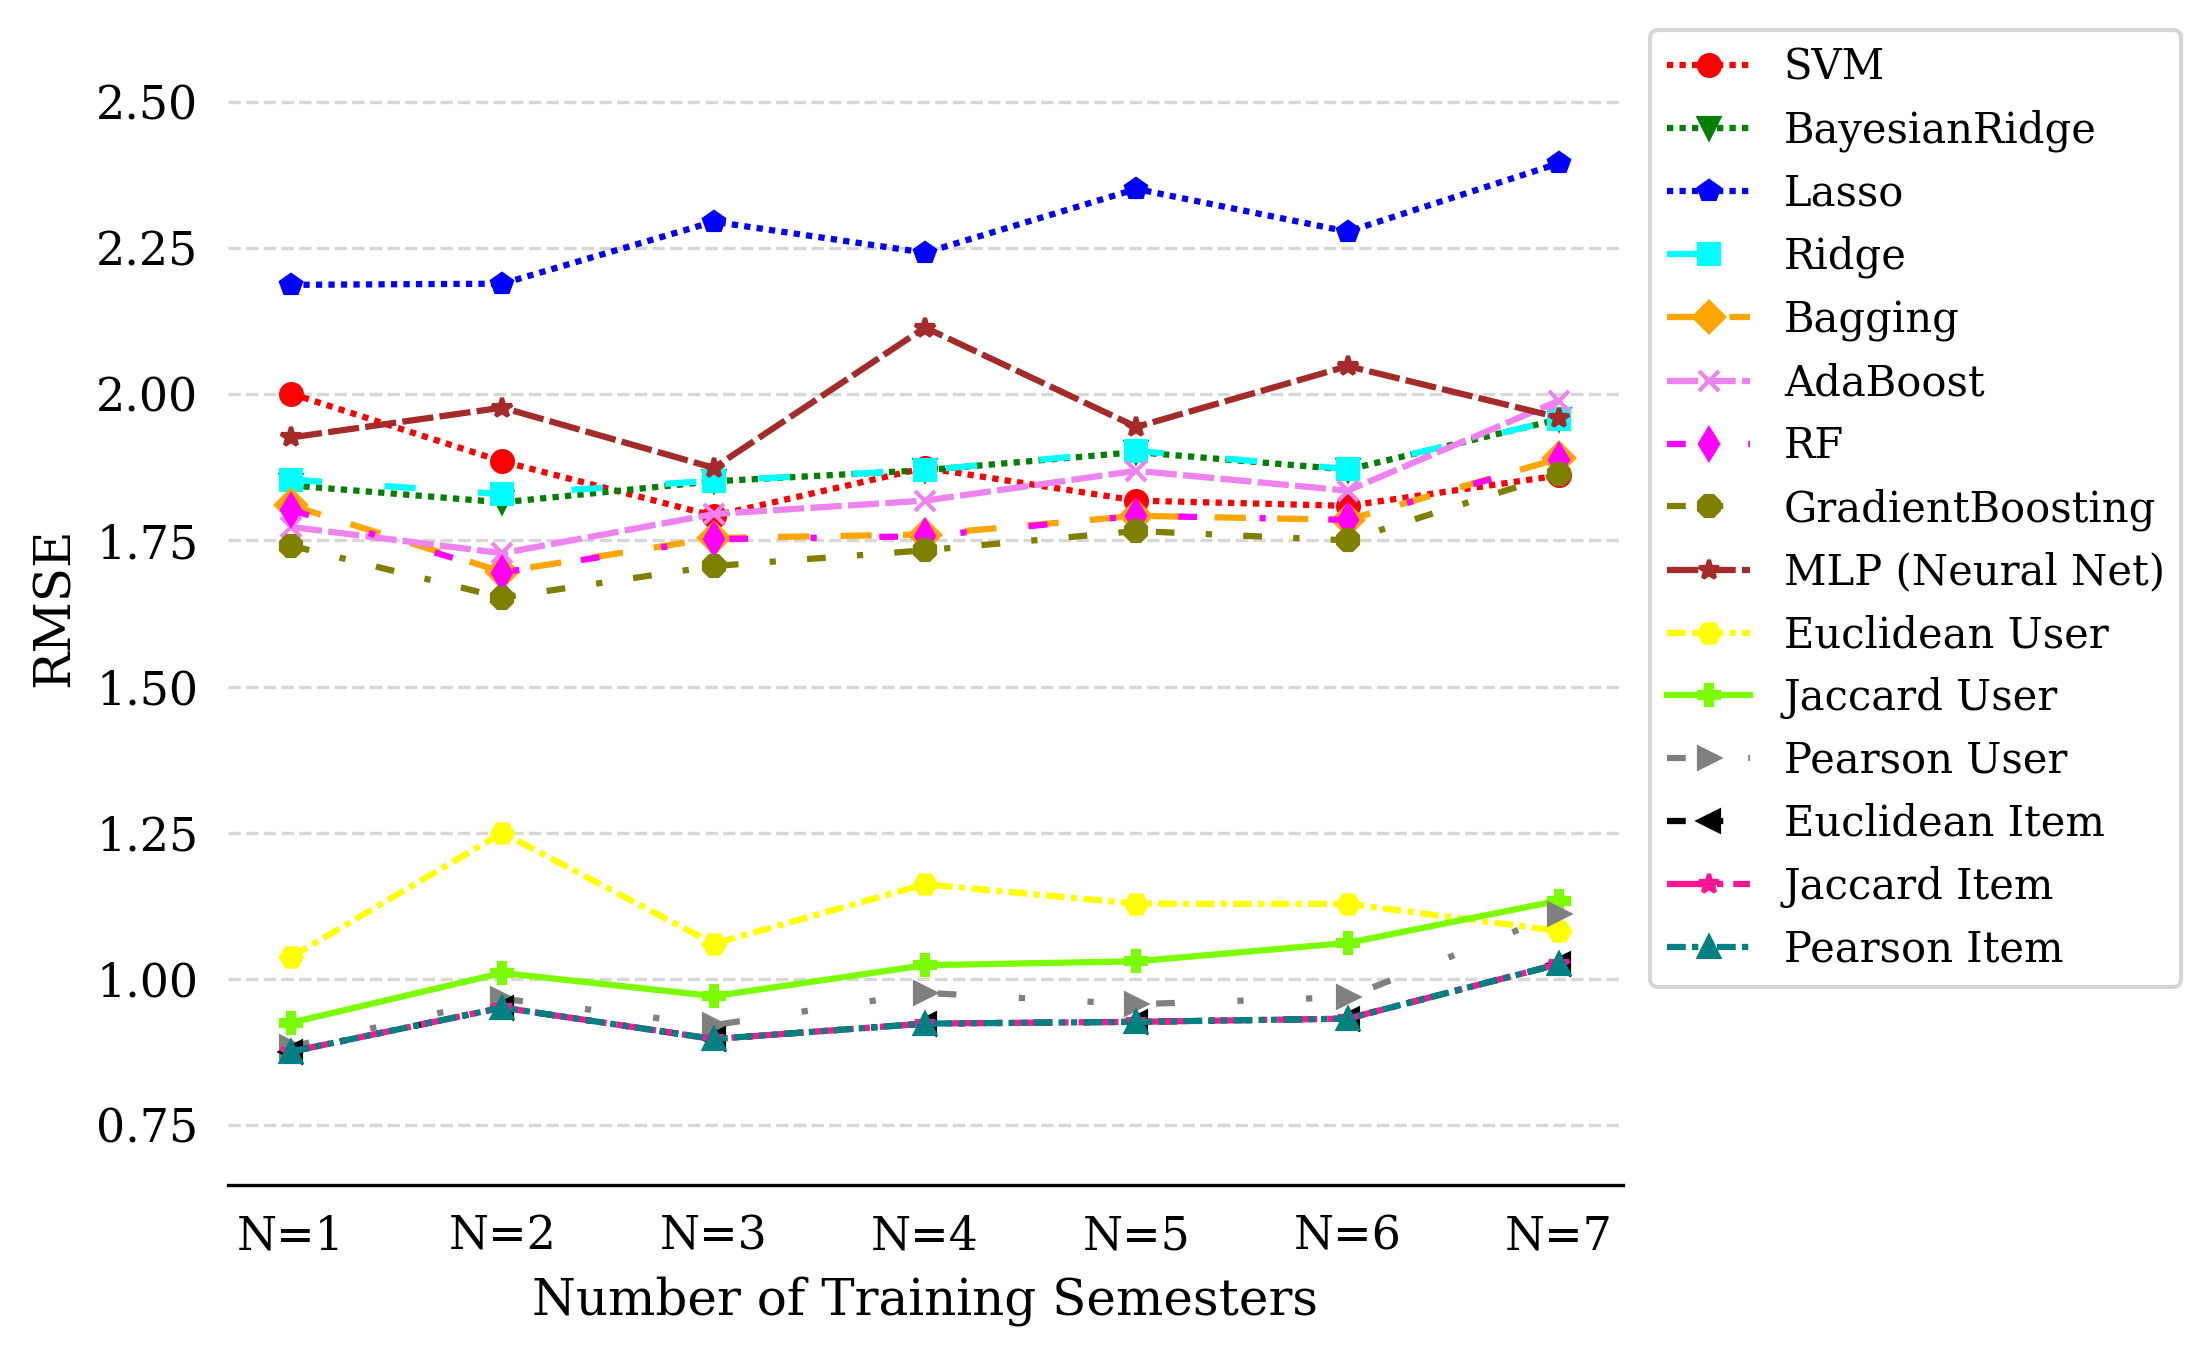

✅ Grafik kaydedildi: error_baseline_rmse.eps


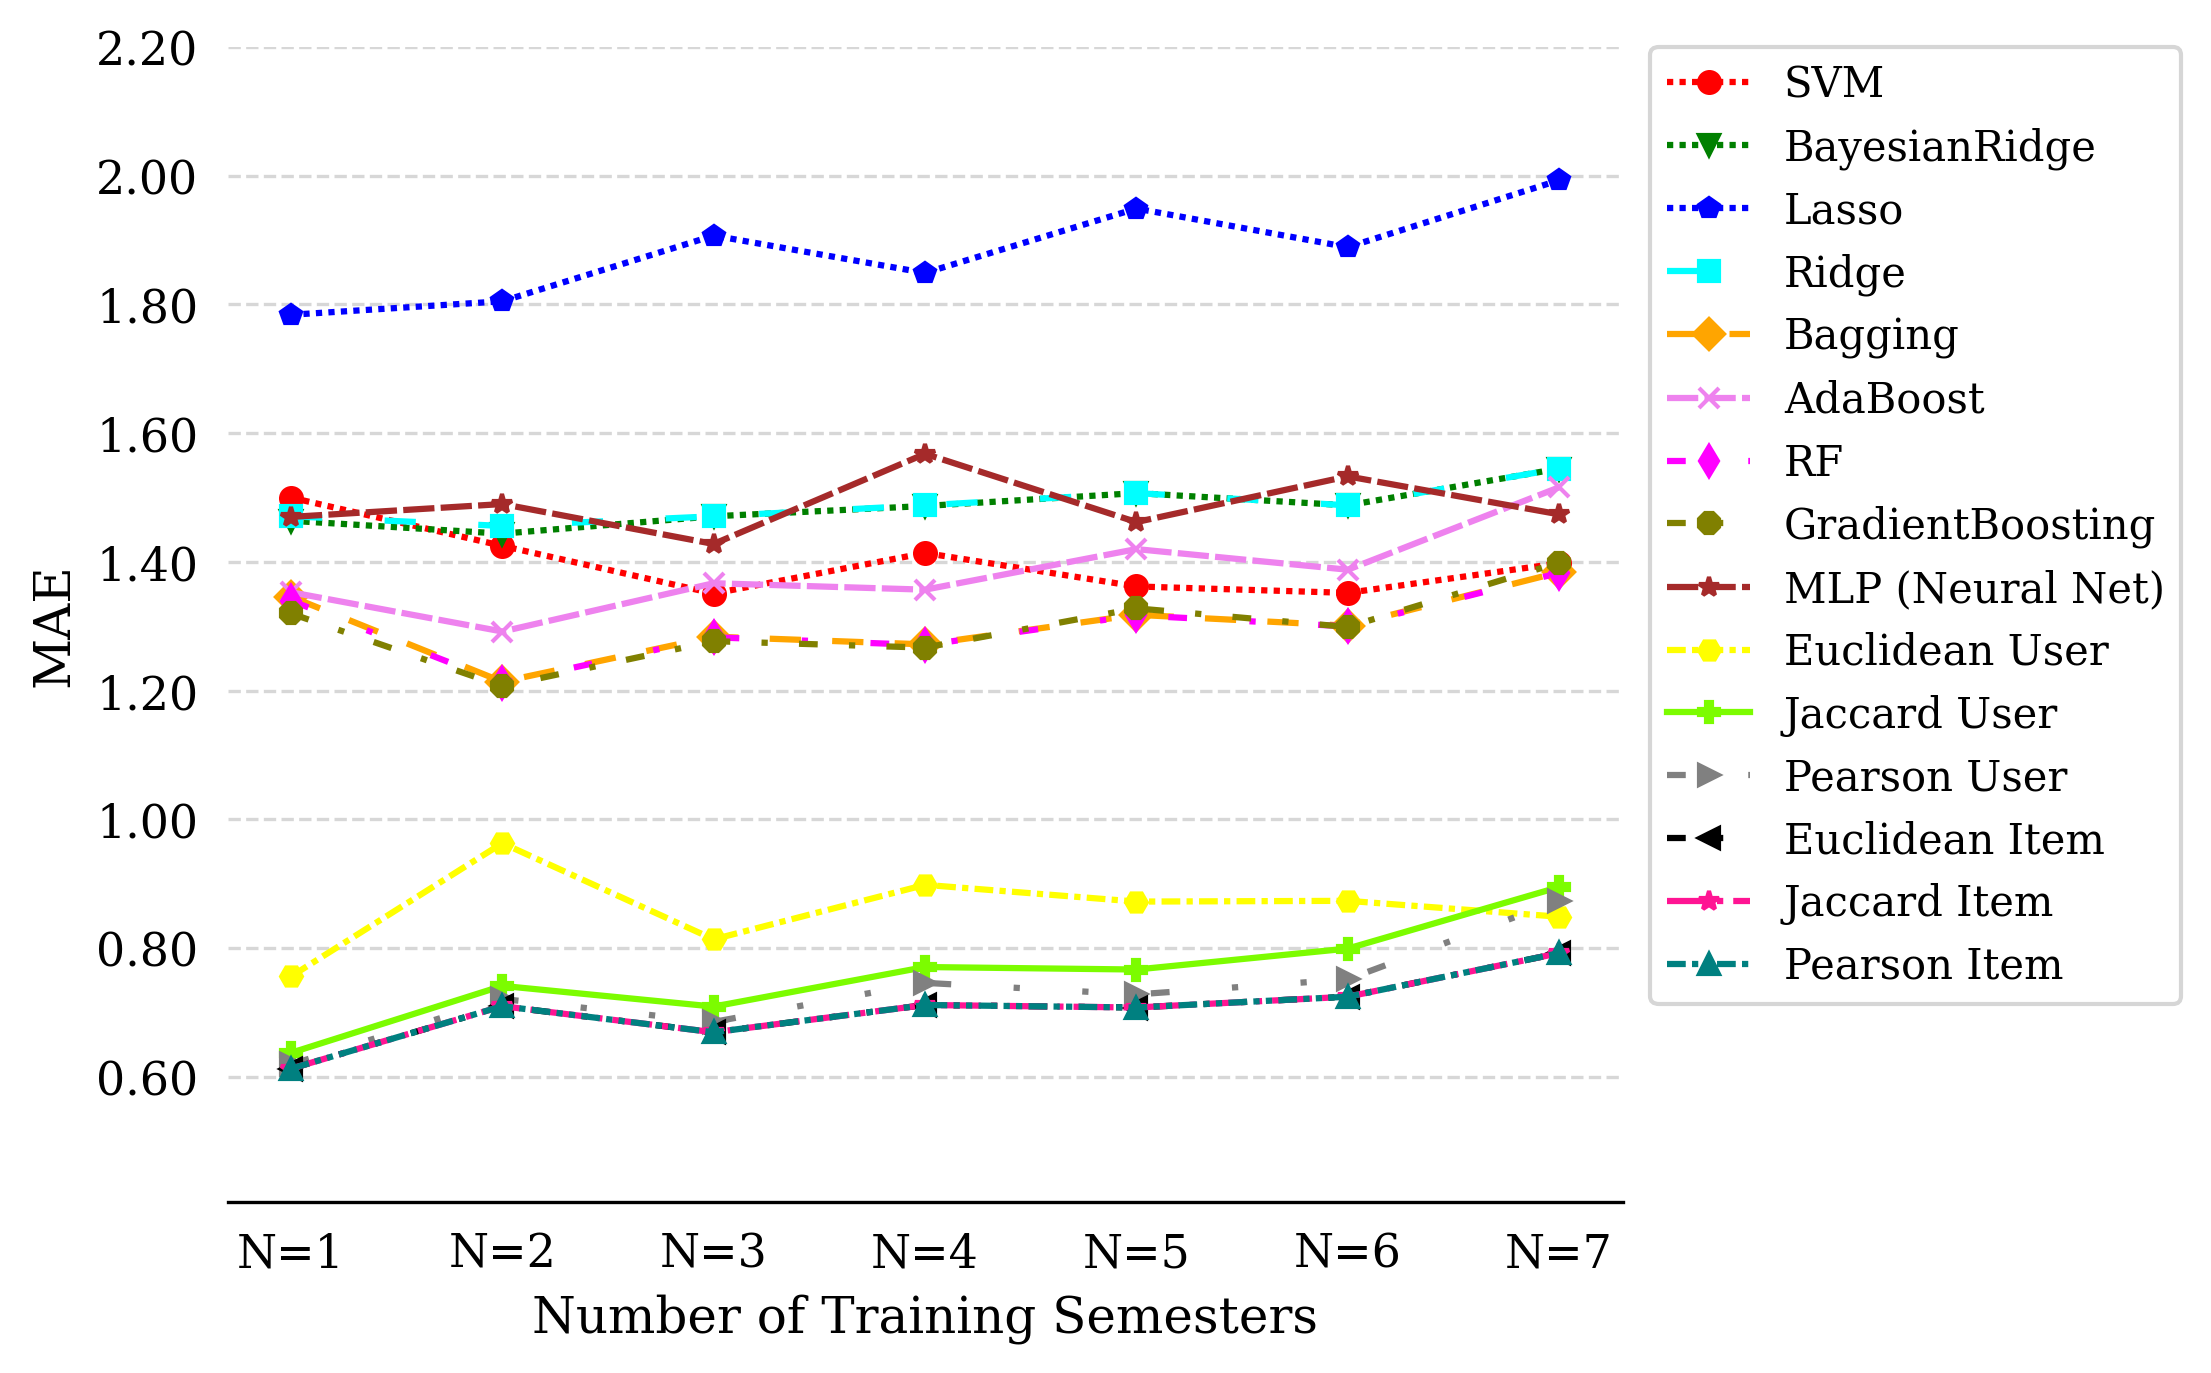

✅ Grafik kaydedildi: error_baseline_mae.eps


In [12]:
# --- KULLANIM ---
# baseline_reg, baseline_cb_user, baseline_cb_item değişkenleri hazır olmalı
plot_baseline_separate(baseline_reg, baseline_cb_user, baseline_cb_item, metric='rmse', suffix='')
plot_baseline_separate(baseline_reg, baseline_cb_user, baseline_cb_item, metric='mae', suffix='')

### Subset Üzerinde Baseline (Yeni)

In [13]:
with open('../results/results_baseline_regression_subset.json') as fr:
    baseline_reg_subset = json.load(fr)   

In [14]:
with open('../results/results_baseline_cf_user_based_subset.json') as fr:
    baseline_cb_user_subset = json.load(fr)   

In [15]:
with open('../results/results_baseline_cf_item_based_subset.json') as fr:
    baseline_cb_item_subset = json.load(fr)   

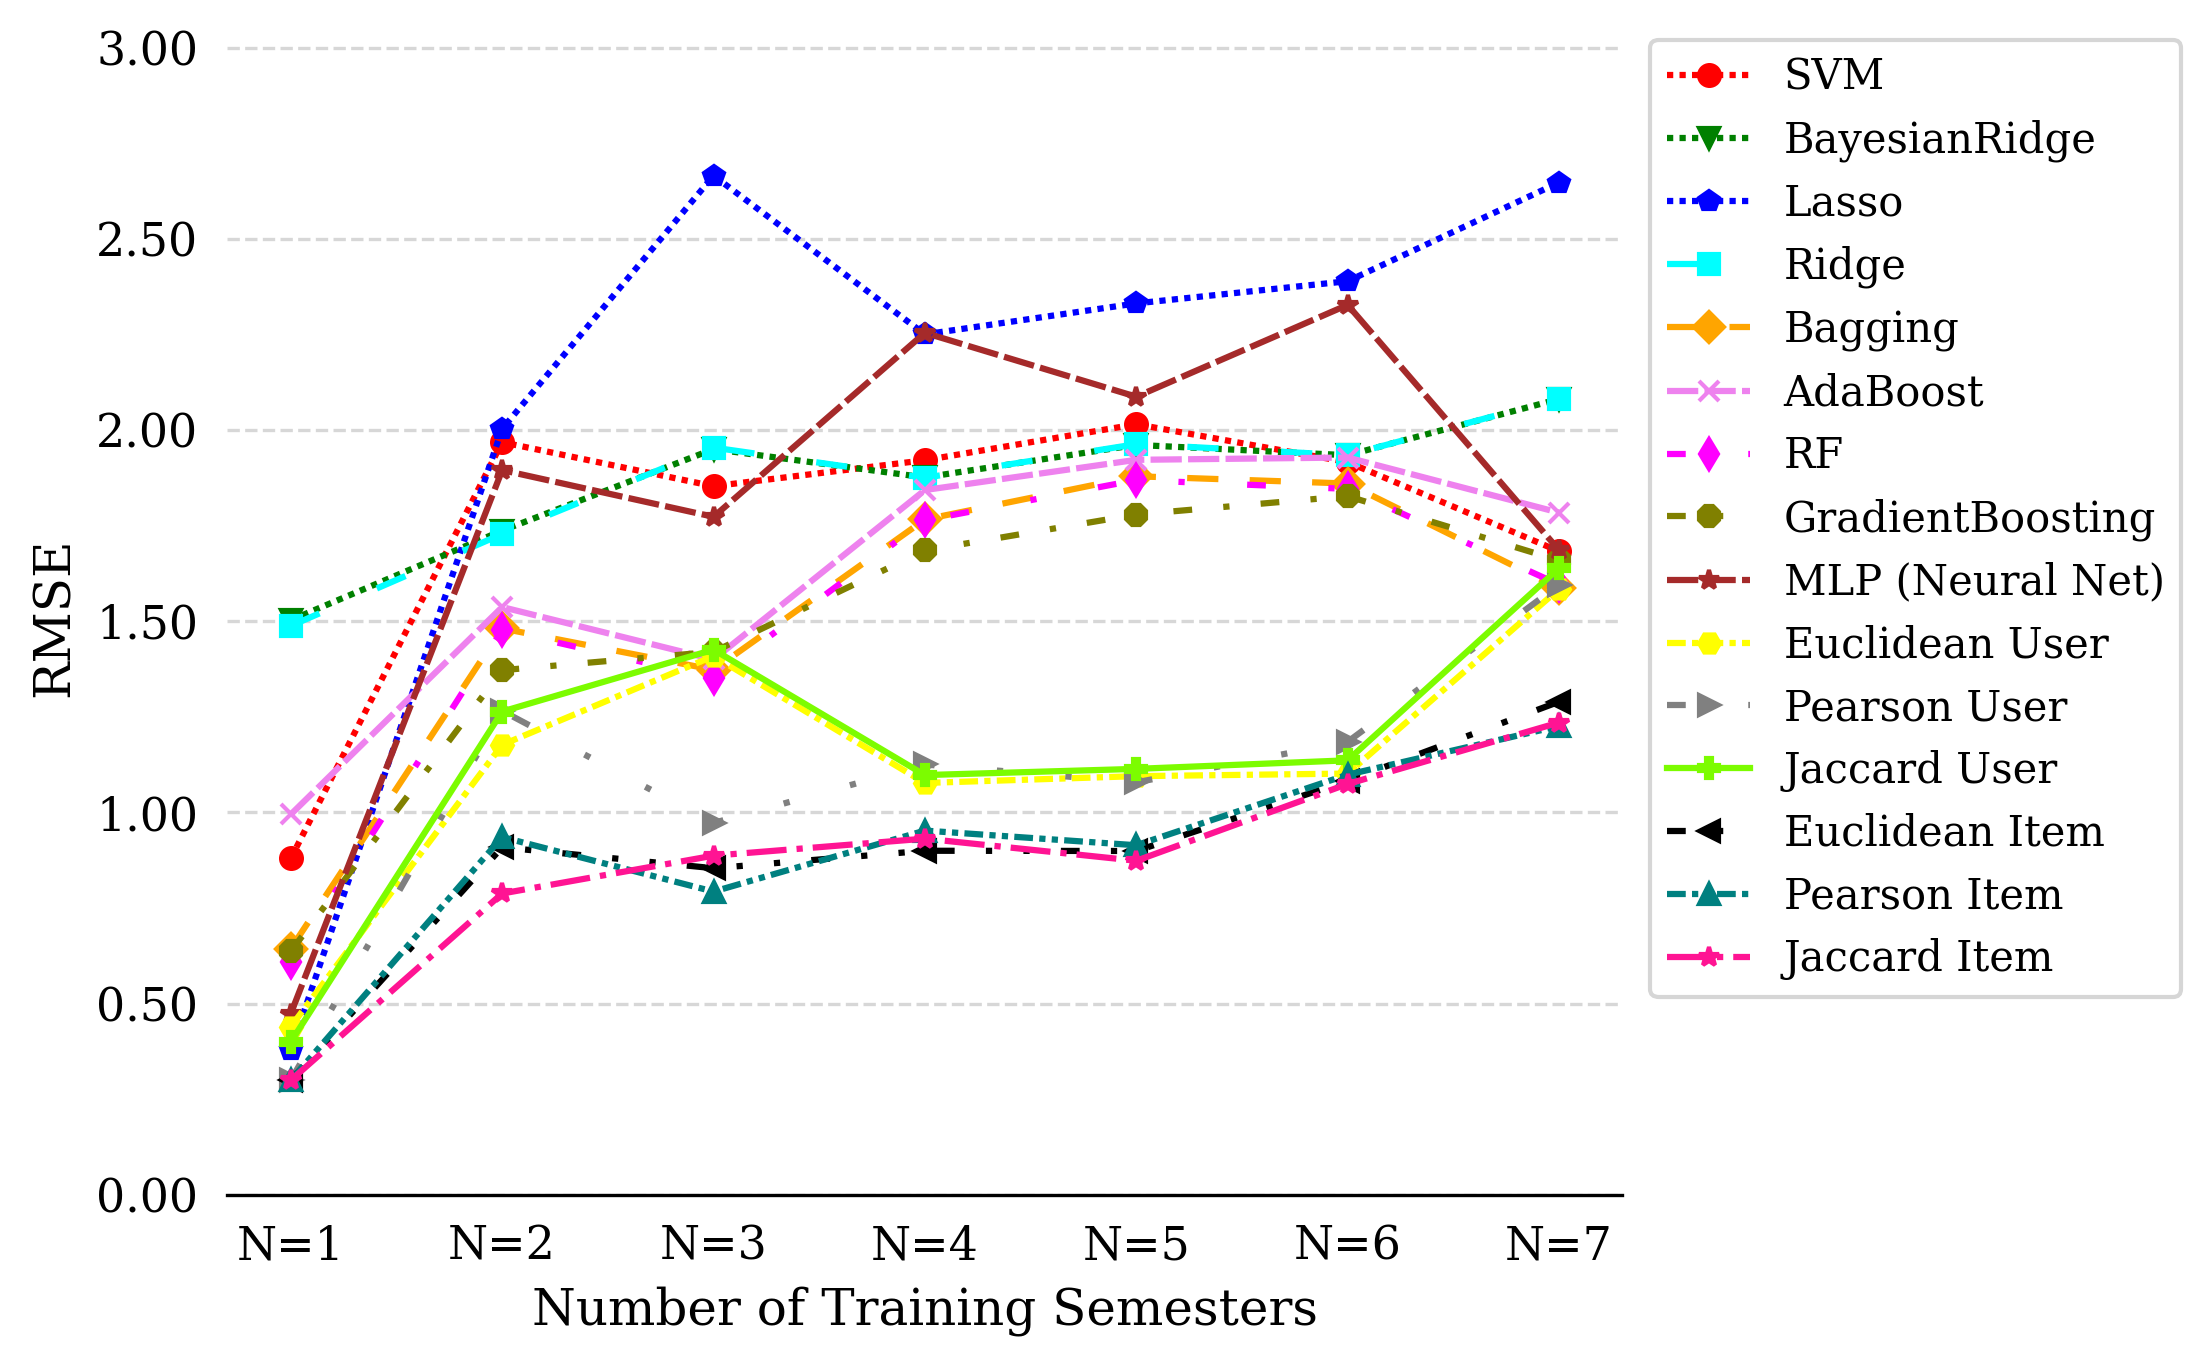

✅ Grafik kaydedildi: error_baseline_rmse_subset.eps


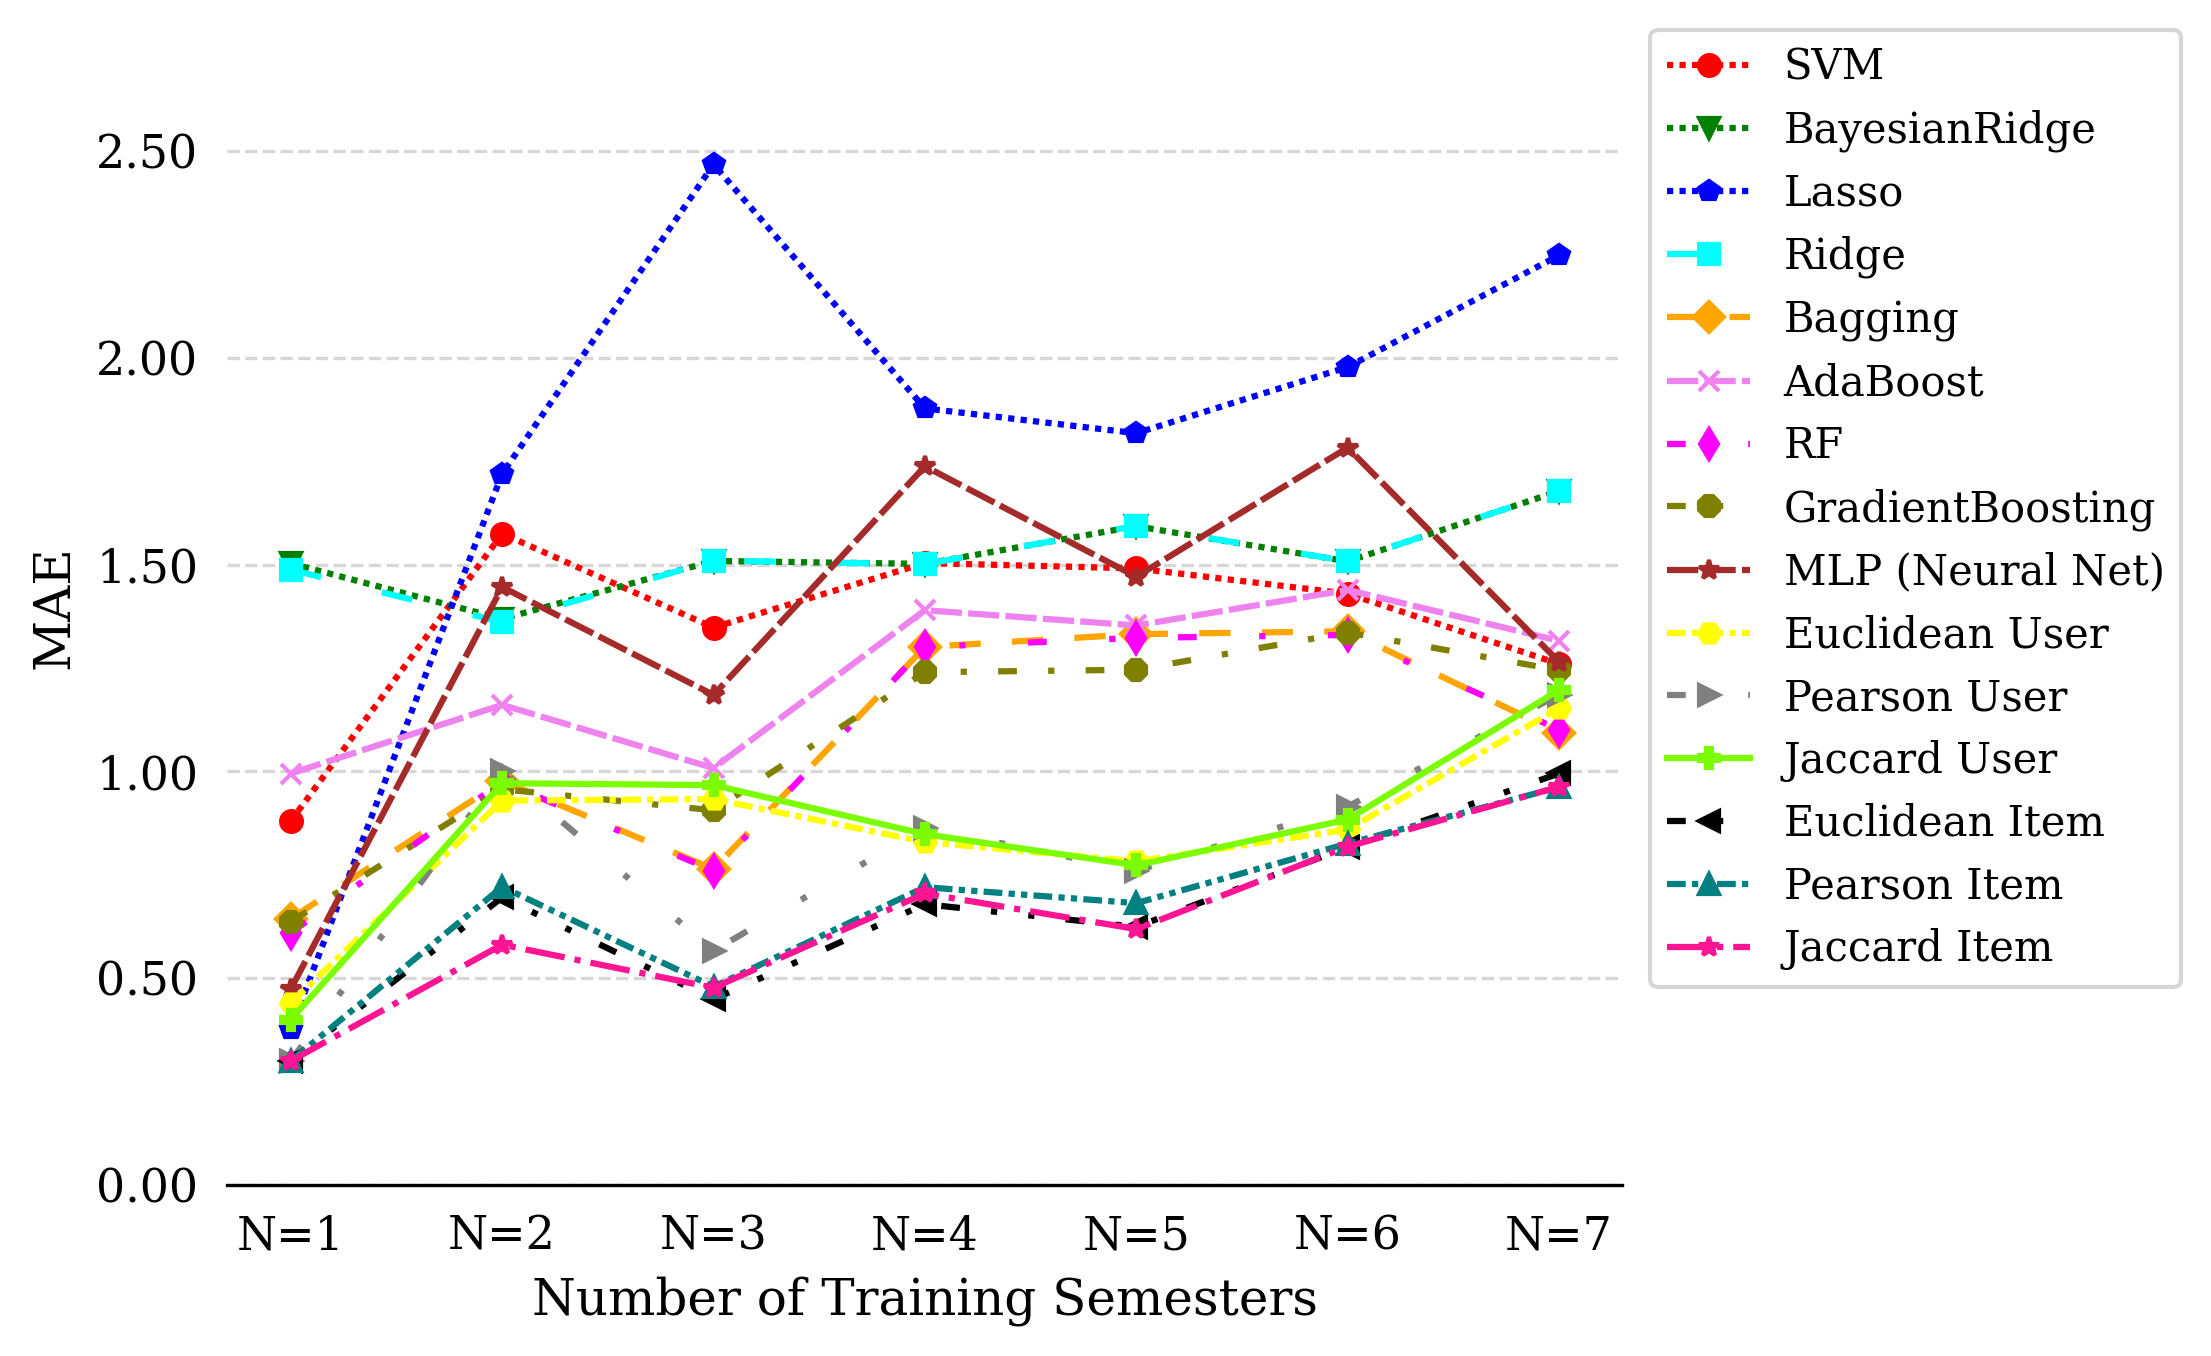

✅ Grafik kaydedildi: error_baseline_mae_subset.eps


In [16]:
# --- KULLANIM ---
# baseline_reg, baseline_cb_user, baseline_cb_item değişkenleri hazır olmalı
plot_baseline_separate(baseline_reg_subset, baseline_cb_user_subset, baseline_cb_item_subset, metric='rmse', suffix='subset')
plot_baseline_separate(baseline_reg_subset, baseline_cb_user_subset, baseline_cb_item_subset, metric='mae', suffix='subset')

### Student-based Clustering:

In [17]:
with open('../results/clustering_student_based_regression_results (with KMeans).json') as fr:
    student_cluster_reg = json.load(fr)   

In [18]:
with open('../results/clustering_user_based_collaborative_filtering_results (Student based with KMeans).json') as fr:
    student_cluster_cb_user = json.load(fr)  

In [19]:
with open('../results/clustering_item_based_collaborative_filtering_results (Student based with KMeans).json') as fr:
    student_cluster_cb_item = json.load(fr)    

In [37]:
def plot_student_based_clustering(reg, cb_user, cb_item):

    # =========================
    # Create separate figures
    # =========================
    fig_rmse, ax_rmse = plt.subplots(figsize=(5.5, 4.5))
    fig_mae,  ax_mae  = plt.subplots(figsize=(5.5, 4.5))

    # =========================
    # Regression
    # =========================
    # print("Regression:")
    errors_reg = {}

    for model in reg:
        errors = {}
        errors_reg[model] = {}

        for num_cluster in reg[model]:
            errors_reg[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in reg[model][num_cluster]:
                y_true = reg[model][num_cluster][n_training_sem]['y_true']
                y_pred = reg[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_reg[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_reg[model][num_cluster][s]['rmse']
                 for s in errors_reg[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_reg[model][num_cluster][s]['mae']
                 for s in errors_reg[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        label = name_mapper.get(model, model)

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=label,
            linestyle=styles[label][2],
            marker=styles[label][1],
            linewidth=1, ms=3, color=styles[label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=label,
            linestyle=styles[label][2],
            marker=styles[label][1],
            linewidth=1, ms=3, color=styles[label][0]
        )

    # =========================
    # CB User
    # =========================
    # print("---------------------------------------------------")
    # print("Cb User")
    errors_cb_user = {}

    for model in cb_user:
        errors = {}
        errors_cb_user[model] = {}

        for num_cluster in cb_user[model]:
            errors_cb_user[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in cb_user[model][num_cluster]:
                y_true = cb_user[model][num_cluster][n_training_sem]['y_true']
                y_pred = cb_user[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_cb_user[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_cb_user[model][num_cluster][s]['rmse']
                 for s in errors_cb_user[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_cb_user[model][num_cluster][s]['mae']
                 for s in errors_cb_user[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        model_label  = model + ' (user-based)'
        model_legend = name_mapper.get(model, model) + 'User'

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

    # =========================
    # CB Item
    # =========================
    # print("---------------------------------------------------")
    # print("Cb Item")
    errors_cb_item = {}

    for model in cb_item:
        errors = {}
        errors_cb_item[model] = {}

        for num_cluster in cb_item[model]:
            errors_cb_item[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in cb_item[model][num_cluster]:
                y_true = cb_item[model][num_cluster][n_training_sem]['y_true']
                y_pred = cb_item[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_cb_item[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_cb_item[model][num_cluster][s]['rmse']
                 for s in errors_cb_item[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_cb_item[model][num_cluster][s]['mae']
                 for s in errors_cb_item[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        model_label  = model + ' (item-based)'
        model_legend = name_mapper.get(model, model) + 'Item'

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

    # =========================
    # Formatting (shared)
    # =========================
    for ax in [ax_rmse, ax_mae]:
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels([f'k={i}' for i in range(10, 31, 5)],
                           fontsize=11, fontfamily='serif')
        ax.grid(axis='y')
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis="both", which="both",
                       bottom=False, top=False,
                       left=False, right=False)

    ax_rmse.set_ylabel('RMSE', fontfamily='serif', fontsize=11)
    ax_mae.set_ylabel('MAE',  fontfamily='serif', fontsize=11)

    ax_rmse.legend(prop={'size': 10, 'family': 'serif'},
                   loc='right', bbox_to_anchor=(1.44, 0.5))
    ax_mae.legend(prop={'size': 10, 'family': 'serif'},
                   loc='right', bbox_to_anchor=(1.44, 0.5))

    # =========================
    # Save figures
    # =========================
    # fig_rmse.savefig('error_cluster_student_rmse.eps',
    #                  bbox_inches='tight', dpi=1200)
    # fig_mae.savefig('error_cluster_student_mae.eps',
    #                 bbox_inches='tight', dpi=1200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


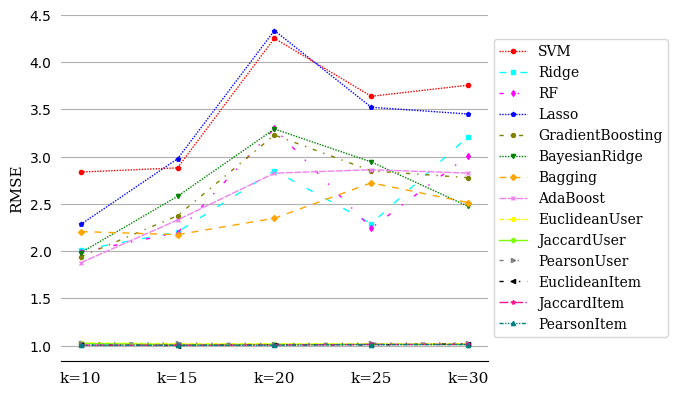

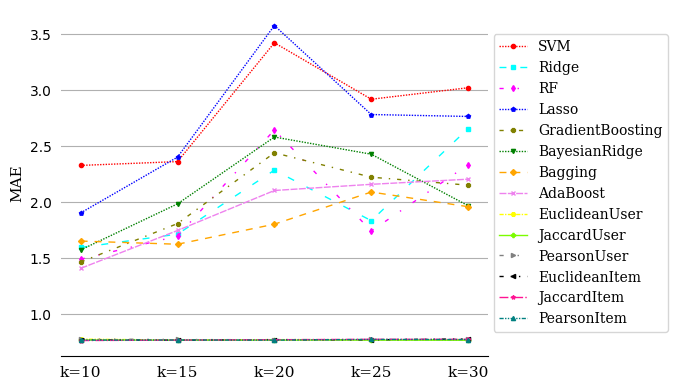

In [27]:
plot_student_based_clustering(student_cluster_reg, student_cluster_cb_user, student_cluster_cb_item)

#### student based standart sapma analizi icin figurleri ayri ayri cizme 

In [28]:
def plot_student_based_clustering_separate(reg, cb_user, cb_item):
    stats_data = {}

    # -------- REGRESSION (split into 2 figures) --------
    reg_parts = split_dict(reg, 4)

    fig_reg_1 = plot_cluster_group(
        reg_parts[0],
        title_suffix="Regression Models (Part I)",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="reg"
    )

    fig_reg_2 = plot_cluster_group(
        reg_parts[1],
        title_suffix="Regression Models (Part II)",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="reg"
    )

    fig_reg_3 = plot_cluster_group(
        reg_parts[2],
        title_suffix="Regression Models (Part III)",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="reg"
    )

    fig_reg_4 = plot_cluster_group(
        reg_parts[3],
        title_suffix="Regression Models (Part IV)",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="reg"
    )

    # -------- USER-BASED CF --------
    fig_user = plot_cluster_group(
        cb_user,
        title_suffix="User-Based Collaborative Filtering",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="user"
    )

    # -------- ITEM-BASED CF --------
    fig_item = plot_cluster_group(
        cb_item,
        title_suffix="Item-Based Collaborative Filtering",
        name_mapper=name_mapper,
        styles=styles,
        stats_data=stats_data,
        tag="item"
    )

    return stats_data, fig_reg_1, fig_reg_2, fig_reg_3, fig_reg_4, fig_user, fig_item

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


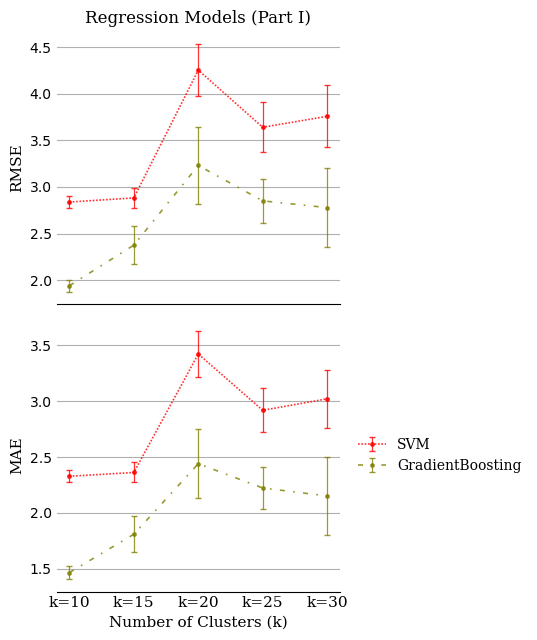

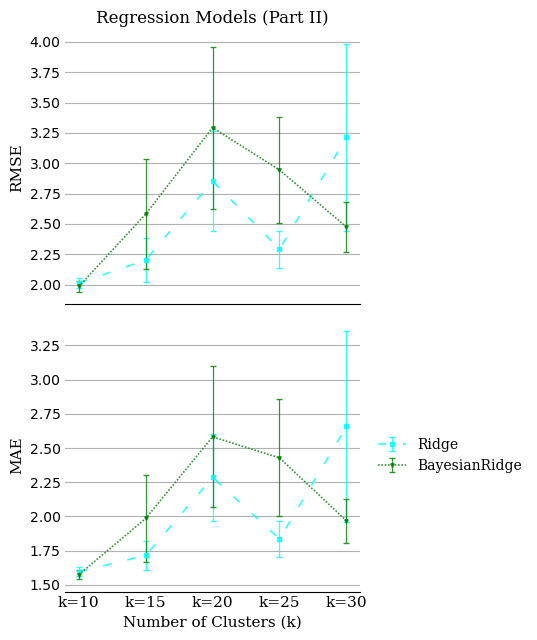

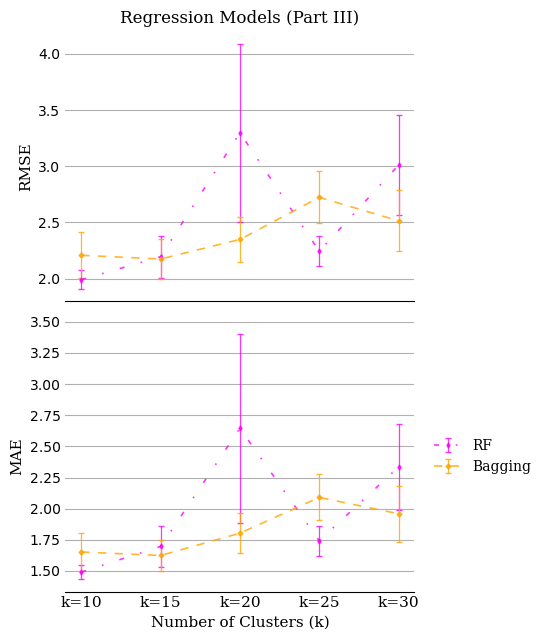

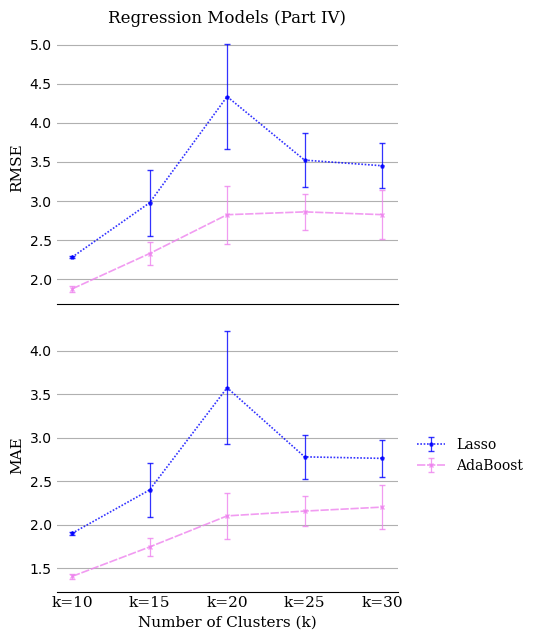

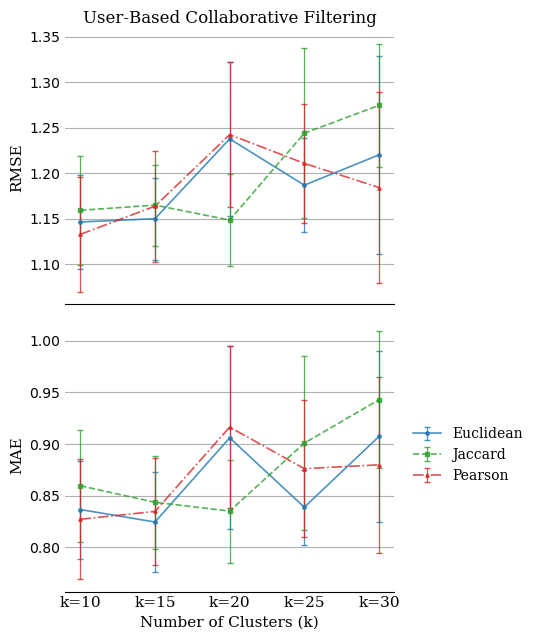

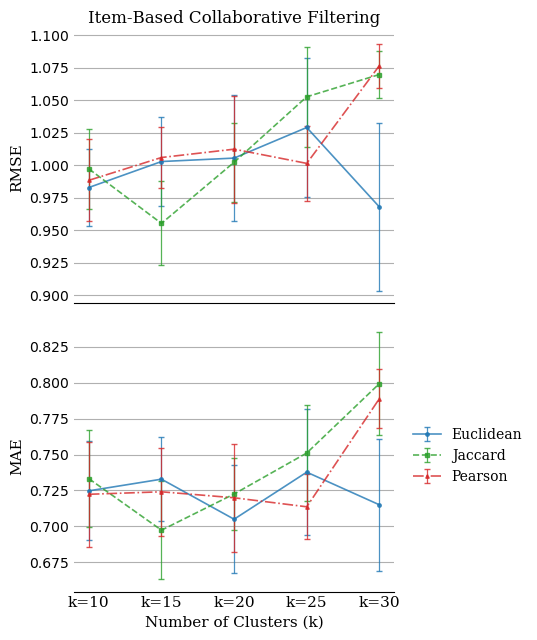

In [ ]:
stats_data, fig_reg_1, fig_reg_2, fig_reg_3, fig_reg_4, fig_user, fig_item = \
    plot_student_based_clustering_separate(
        student_cluster_reg,
        student_cluster_cb_user,
        student_cluster_cb_item
    )

# fig_reg_1.savefig("student_based_regression_clusters_part1.eps", dpi=1200, bbox_inches="tight")
# fig_reg_2.savefig("student_based_regression_clusters_part2.eps", dpi=1200, bbox_inches="tight")
# fig_reg_3.savefig("student_based_regression_clusters_part3.eps", dpi=1200, bbox_inches="tight")
# fig_reg_4.savefig("student_based_regression_clusters_part4.eps", dpi=1200, bbox_inches="tight")
# fig_user.savefig("student_based_user_cf_clusters.eps", dpi=1200, bbox_inches="tight")
# fig_item.savefig("student_based_item_cf_clusters.eps", dpi=1200, bbox_inches="tight")

### Course-based Clustering:

In [30]:
with open('../results/clustering_course_based_regression_results (with KMeans).json') as fr:
    course_cluster_reg = json.load(fr)    

In [31]:
with open('../results/clustering_user_based_collaborative_filtering_results (Course based with KMeans).json') as fr:
    course_cluster_cb_user = json.load(fr)    

In [32]:
with open('../results/clustering_item_based_collaborative_filtering_results (Course based with KMeans).json') as fr:
    course_cluster_cb_item = json.load(fr)    

In [38]:
def plot_course_based_clustering(reg, cb_user, cb_item):

    # =========================
    # Create separate figures
    # =========================
    fig_rmse, ax_rmse = plt.subplots(figsize=(5.5, 4.5))
    fig_mae,  ax_mae  = plt.subplots(figsize=(5.5, 4.5))

    # =========================
    # Regression
    # =========================
    # print("Regression:")
    errors_reg = {}

    for model in reg:
        errors = {}
        errors_reg[model] = {}

        for num_cluster in reg[model]:
            errors_reg[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in reg[model][num_cluster]:
                y_true = reg[model][num_cluster][n_training_sem]['y_true']
                y_pred = reg[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_reg[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_reg[model][num_cluster][s]['rmse']
                 for s in errors_reg[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_reg[model][num_cluster][s]['mae']
                 for s in errors_reg[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        label = name_mapper.get(model, model)

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=label,
            linestyle=styles[label][2],
            marker=styles[label][1],
            linewidth=1, ms=3, color=styles[label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=label,
            linestyle=styles[label][2],
            marker=styles[label][1],
            linewidth=1, ms=3, color=styles[label][0]
        )

    # =========================
    # CB User
    # =========================
    # print("---------------------------------------------------")
    # print("Cb User")
    errors_cb_user = {}

    for model in cb_user:
        errors = {}
        errors_cb_user[model] = {}

        for num_cluster in cb_user[model]:
            errors_cb_user[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in cb_user[model][num_cluster]:
                y_true = cb_user[model][num_cluster][n_training_sem]['y_true']
                y_pred = cb_user[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_cb_user[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_cb_user[model][num_cluster][s]['rmse']
                 for s in errors_cb_user[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_cb_user[model][num_cluster][s]['mae']
                 for s in errors_cb_user[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        model_label  = model + ' (user-based)'
        model_legend = name_mapper.get(model, model) + 'User'

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

    # =========================
    # CB Item
    # =========================
    # print("---------------------------------------------------")
    # print("Cb Item")
    errors_cb_item = {}

    for model in cb_item:
        errors = {}
        errors_cb_item[model] = {}

        for num_cluster in cb_item[model]:
            errors_cb_item[model][num_cluster] = {}
            errors.setdefault(num_cluster, {'rmse': 100, 'mae': 100})

            for n_training_sem in cb_item[model][num_cluster]:
                y_true = cb_item[model][num_cluster][n_training_sem]['y_true']
                y_pred = cb_item[model][num_cluster][n_training_sem]['y_pred']

                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                mae  = mean_absolute_error(y_true, y_pred)

                errors_cb_item[model][num_cluster][n_training_sem] = {
                    'rmse': rmse,
                    'mae': mae
                }

            errors[num_cluster]['rmse'] = np.mean(
                [errors_cb_item[model][num_cluster][s]['rmse']
                 for s in errors_cb_item[model][num_cluster]]
            )
            errors[num_cluster]['mae'] = np.mean(
                [errors_cb_item[model][num_cluster][s]['mae']
                 for s in errors_cb_item[model][num_cluster]]
            )

        # print(f"{model}: {errors}")

        rmse = {k: v['rmse'] for k, v in sorted(errors.items())}
        mae  = {k: v['mae']  for k, v in sorted(errors.items())}

        model_label  = model + ' (item-based)'
        model_legend = name_mapper.get(model, model) + 'Item'

        ax_rmse.plot(
            np.arange(5), list(rmse.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

        ax_mae.plot(
            np.arange(5), list(mae.values()),
            label=model_legend,
            linestyle=styles[model_label][2],
            marker=styles[model_label][1],
            linewidth=1, ms=3, color=styles[model_label][0]
        )

    # =========================
    # Formatting
    # =========================
    for ax in [ax_rmse, ax_mae]:
        ax.set_xticks(np.arange(5))
        ax.set_xticklabels([f'k={i}' for i in range(10, 31, 5)],
                           fontsize=11, fontfamily='serif')
        ax.grid(axis='y')
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.tick_params(axis="both", which="both",
                       bottom=False, top=False,
                       left=False, right=False)

    ax_rmse.set_ylabel('RMSE', fontfamily='serif', fontsize=11)
    ax_mae.set_ylabel('MAE',  fontfamily='serif', fontsize=11)

    ax_rmse.set_yticks(np.arange(0.8, 4.2, 0.2))
    ax_rmse.set_yticklabels([round(i, 2) for i in np.arange(0.8, 4.2, 0.2)],
                            fontfamily='serif', fontsize=11)

    ax_mae.set_yticks(np.arange(0.6, 4.6, 0.2))
    ax_mae.set_yticklabels([round(i, 2) for i in np.arange(0.6, 4.6, 0.2)],
                           fontfamily='serif', fontsize=11)

    ax_rmse.legend(prop={'size': 10, 'family': 'serif'},
                   loc='right', bbox_to_anchor=(1.44, 0.5))
    ax_mae.legend(prop={'size': 10, 'family': 'serif'},
                   loc='right', bbox_to_anchor=(1.44, 0.5))

    # =========================
    # Save figures
    # =========================
    # fig_rmse.savefig('error_cluster_course_rmse.eps',
    #                  bbox_inches='tight', dpi=1200)
    # fig_mae.savefig('error_cluster_course_mae.eps',
    #                 bbox_inches='tight', dpi=1200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


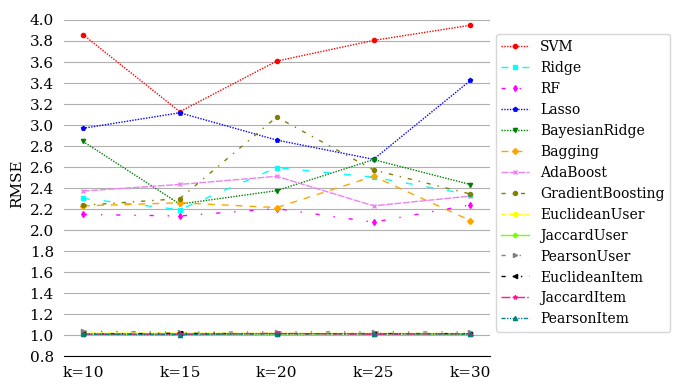

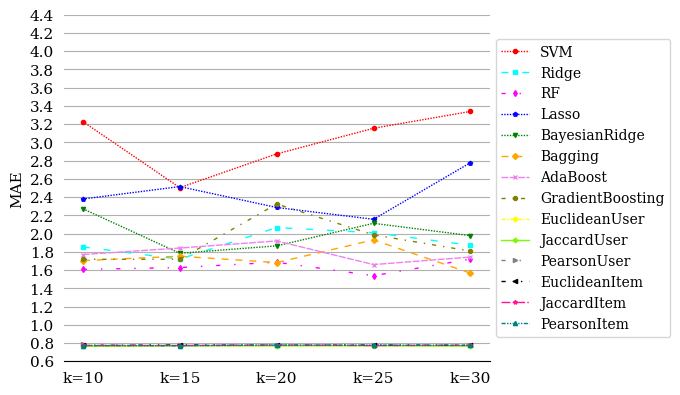

In [36]:
plot_course_based_clustering(course_cluster_reg, course_cluster_cb_user, course_cluster_cb_item)

#### course based standart sapma analizi icin figurleri ayri ayri cizme 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


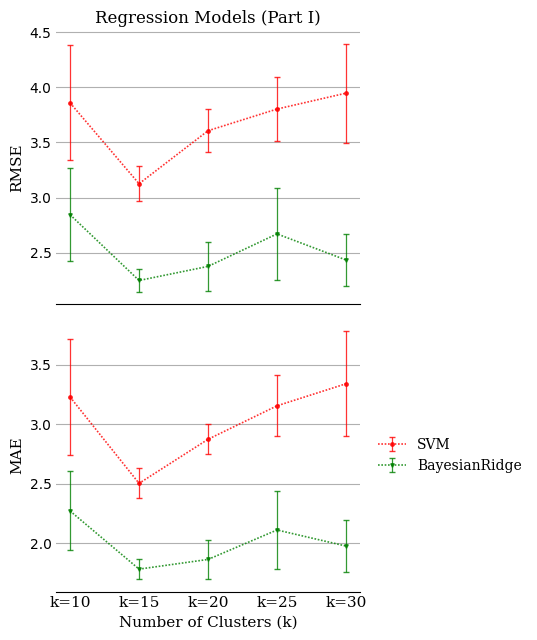

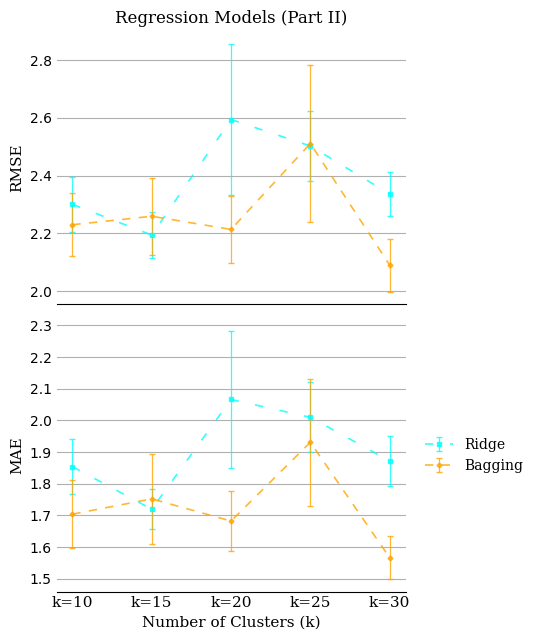

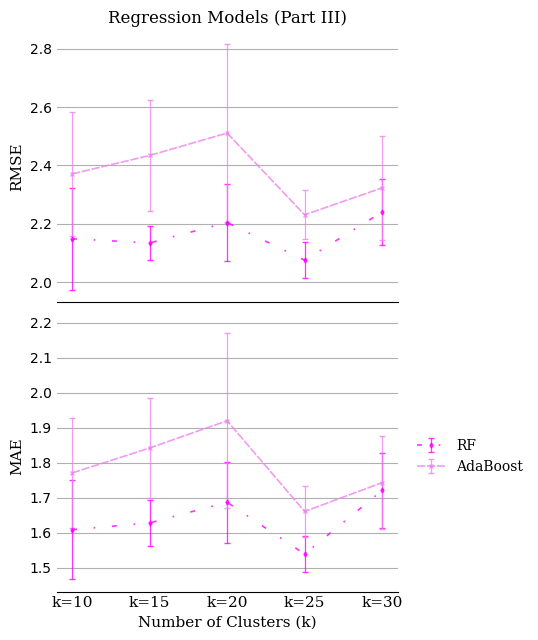

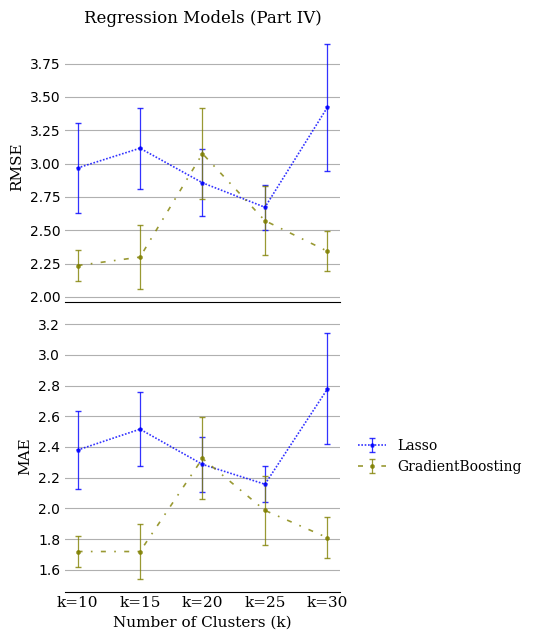

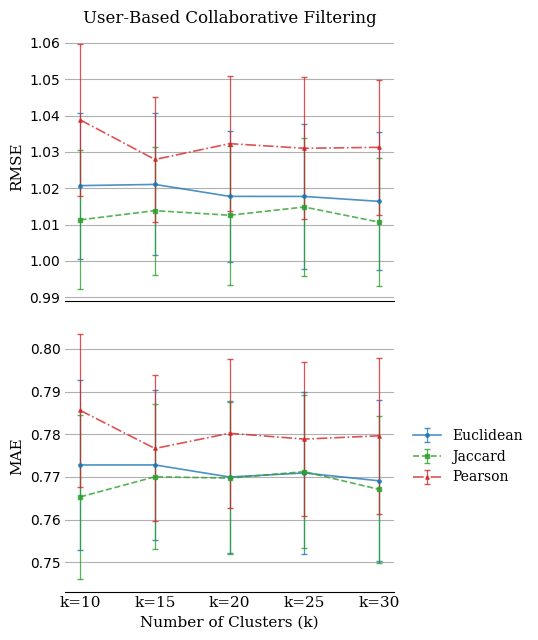

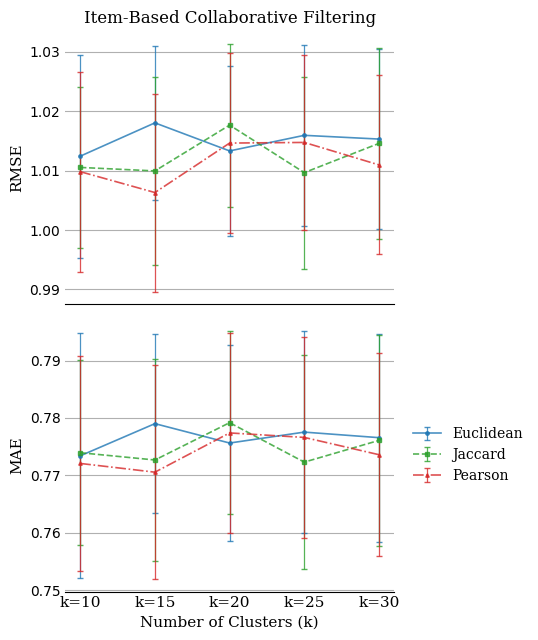

In [ ]:
stats_data, fig_reg_1, fig_reg_2, fig_reg_3, fig_reg_4, fig_user, fig_item = \
    plot_student_based_clustering_separate(
        course_cluster_reg,
        course_cluster_cb_user,
        course_cluster_cb_item
    )

# fig_reg_1.savefig("course_based_regression_clusters_part1.eps", dpi=1200, bbox_inches="tight")
# fig_reg_2.savefig("course_based_regression_clusters_part2.eps", dpi=1200, bbox_inches="tight")
# fig_reg_3.savefig("course_based_regression_clusters_part3.eps", dpi=1200, bbox_inches="tight")
# fig_reg_4.savefig("course_based_regression_clusters_part4.eps", dpi=1200, bbox_inches="tight")
# fig_user.savefig("course_based_user_cf_clusters.eps", dpi=1200, bbox_inches="tight")
# fig_item.savefig("course_based_item_cf_clusters.eps", dpi=1200, bbox_inches="tight")

### Comparison with the state of the art

#### selecting our best model and k value for sota comparison

In [54]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def convert_to_benchmark_format(input_data, model_name="Proposed Method"):
    """
    JSON çıktısını benchmark formatına çevirir ve kullanılan metriği de ekler.
    """
    # 1. Metriği Yakala (Zaten yapıyorduk, şimdi kullanacağız)
    sim_metric = list(input_data.keys())[0] 
    clusters_data = input_data[sim_metric]
    
    # 2. En İyi k Değerini Bul
    best_k = None
    min_global_rmse = float('inf')
    
    for k_val in clusters_data:
        all_true = []
        all_pred = []
        for sem in clusters_data[k_val]:
            all_true.extend(clusters_data[k_val][sem]['y_true'])
            all_pred.extend(clusters_data[k_val][sem]['y_pred'])
            
        if not all_true: continue
            
        rmse = np.sqrt(mean_squared_error(all_true, all_pred))
        if rmse < min_global_rmse:
            min_global_rmse = rmse
            best_k = k_val
            
    # --- BURASI GÜNCELLENDİ (Bilgi Veriyoruz) ---
    print(f"Algılanan Metrik: {sim_metric}")  # <--- Hangi metrik olduğunu yazar
    print(f"En iyi sonuç veren parametre: k={best_k} (RMSE: {min_global_rmse:.4f})")
    
    # 3. İstenilen Formata Dönüştür
    # Model isminin yanına metriği de ekleyelim ki karışmasın
    final_model_name = f"{model_name} ({sim_metric})"
    
    formatted_output = {final_model_name: {}}
    
    target_data = clusters_data[best_k] 
    
    for sem_id, results in target_data.items():
        y_true = results['y_true']
        y_pred = results['y_pred']
        
        if not y_true:
            formatted_output[final_model_name][sem_id] = {"rmse": [0.0, 0.0], "mae": [0.0, 0.0]}
            continue
            
        rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
        mae_val = mean_absolute_error(y_true, y_pred)
        
        formatted_output[final_model_name][sem_id] = {
            "rmse": [0.0, rmse_val],
            "mae":  [0.0, mae_val]
        }
        
    return formatted_output

# --- KULLANIM ---
# file_path = '../experiments/clustering_item_based_collaborative_filtering_results (Student based with KMeans).json'
file_path = '../results/clustering_item_based_collaborative_filtering_results (Student based with KMeans).json'

try:
    with open(file_path, 'r') as f:
        my_raw_data = json.load(f)

    # Fonksiyonu çağır
    clean_json = convert_to_benchmark_format(my_raw_data, model_name="Proposed Method")

    # print("\n--- SONUÇ ---")
    # Çıktıda artık "Proposed Method (Euclidean Distance)" yazacak
    # print(json.dumps(clean_json, indent=4))
    
    with open('proposed_method.json', 'w') as fw:
        json.dump(clean_json, fw, indent=4)

    print("✅ Sota comparison icin en iyi model 'proposed_method.json' dosyasına kaydedildi.")
except FileNotFoundError:
    print("Dosya bulunamadı.")

Algılanan Metrik: Euclidean Distance
En iyi sonuç veren parametre: k=15 (RMSE: 1.0111)
✅ Sota comparison icin en iyi model 'proposed_method.json' dosyasına kaydedildi.


In [41]:
with open('../results/nn_results.json') as fr:
    nn = json.load(fr)    

In [42]:
with open('../results/naive_bayes_results.json') as fr:
    nb = json.load(fr)    

In [43]:
with open('../results/2017 paper.json') as fr:
    cb_2017 = json.load(fr)    

In [55]:
with open('proposed_method.json') as fr:
    cf_2026 = json.load(fr)    

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_final_comparison_styled(nn, nb, cb_2017, cf_2026, metric="RMSE"):
    """
    Verileri senin kaynaklarından okur, 'plot_sota_styled' fonksiyonunun
    modern stilini kullanır. 
    ÖNEMLİ: 'CF - Ibrahimzada et al. (2026)' modeli her zaman EN BAŞTA yer alır.
    """
    final_scores = {}
    
    # --- 1. VERİ İŞLEME ---
    
    # CB 2017 İşleme
    try:
        if metric.lower() == 'rmse':
            cb_list = cb_2017['Euclidean Distance']['rmse']
        else: # MAE
            cb_list = cb_2017['Euclidean Distance']['mae']
        final_scores['CB - Cakmak\n(2017)'] = np.mean(cb_list)
    except KeyError:
        print("UYARI: CB 2017 formatı beklenenden farklı!")

    # Diğer Modelleri İşleme
    def process_standard_format(data_dict, custom_name=None):
        for model_key, semesters in data_dict.items():
            test_errors = []
            for sem_id, stats in semesters.items():
                metric_key = 'rmse' if 'rmse' in stats else 'mae'
                if metric.lower() in stats:
                     metric_key = metric.lower()
                
                if len(stats[metric_key]) > 1:
                    test_errors.append(stats[metric_key][1])
                else:
                    test_errors.append(stats[metric_key][0])
            
            if custom_name:
                display_name = custom_name
            else:
                if model_key == 'GaussianNB': display_name = 'GNB - Mimis\net al. (2019)'
                elif model_key == 'MultinomialNB': display_name = 'MNB - Mimis\net al. (2019)'
                elif model_key == 'NN': display_name = 'NN - Mimis\net al. (2019)'
                else: display_name = model_key
            
            if test_errors:
                final_scores[display_name] = np.mean(test_errors)

    # Verileri Çek (Bizim modelin adı burada belirleniyor)
    target_name = "CF - Ibrahimzada\n et al. (2026)"
    process_standard_format(nn)
    process_standard_format(nb)
    process_standard_format(cf_2026, custom_name=target_name)

    # --- 2. ÇİZİM (Sıralama Değişikliği Buraya Eklendi) ---
    if not final_scores:
        print("Çizilecek veri bulunamadı.")
        return

    # A) Önce herkesi skoruna göre (Küçükten Büyüğe) sırala
    sorted_by_score = sorted(final_scores.items(), key=lambda x: x[1])
    
    # B) Bizim modeli bul ve listenin en başına al
    proposed_item = None
    others = []
    
    for item in sorted_by_score:
        if item[0] == target_name:
            proposed_item = item
        else:
            others.append(item)
            
    # C) Yeni Listeyi Oluştur: [Bizimki] + [Diğerleri Sıralı]
    if proposed_item:
        final_sorted_items = [proposed_item] + others
    else:
        final_sorted_items = others # Bulamazsa normal kalsın
        
    labels_sorted = [item[0] for item in final_sorted_items]
    values_sorted = [item[1] for item in final_sorted_items]

    # Renk Paleti (Sıraya göre renk atama)
    color_palette = ['#4C72B0', '#55A868', '#79cdcd', '#F1C40F', '#F39C12', '#E74C3C']
    current_colors = color_palette[:len(values_sorted)]
    
    x = np.arange(len(labels_sorted))
    
    # Çizim Başlat
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Barları Çiz
    bars = ax.bar(x, values_sorted, color=current_colors, width=0.6)
    
    # Değerleri Yaz
    max_val = max(values_sorted) if values_sorted else 1
    offset = max_val * 0.02
    
    for i, val in enumerate(values_sorted):
        ax.text(
            x[i], 
            val + offset, 
            f"{val:.2f}", 
            ha='center', va='bottom', 
            fontsize=11, fontweight='bold', color='black'
        )
    
    # Eksen ve Stil Ayarları
    ax.set_ylabel(metric.upper(), fontsize=12)
    ax.set_ylim(0, max_val * 1.15) 
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels_sorted, rotation=0, ha='center', fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    filename = f"Final_SOTA_Comparison_{metric}.eps"
    plt.savefig(filename, format="eps", bbox_inches='tight')
    print(f"Grafik kaydedildi: {filename}")
    plt.show()

Grafik kaydedildi: Final_SOTA_Comparison_RMSE.eps


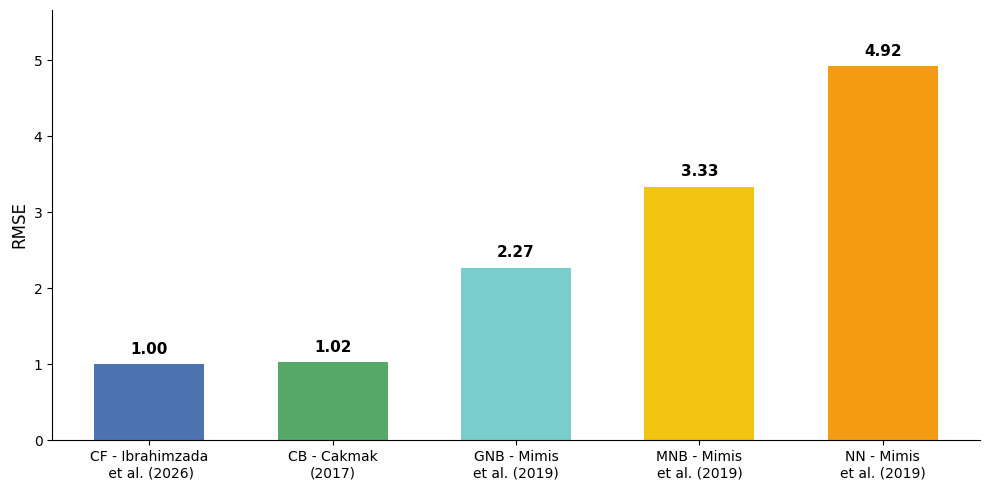

Grafik kaydedildi: Final_SOTA_Comparison_MAE.eps


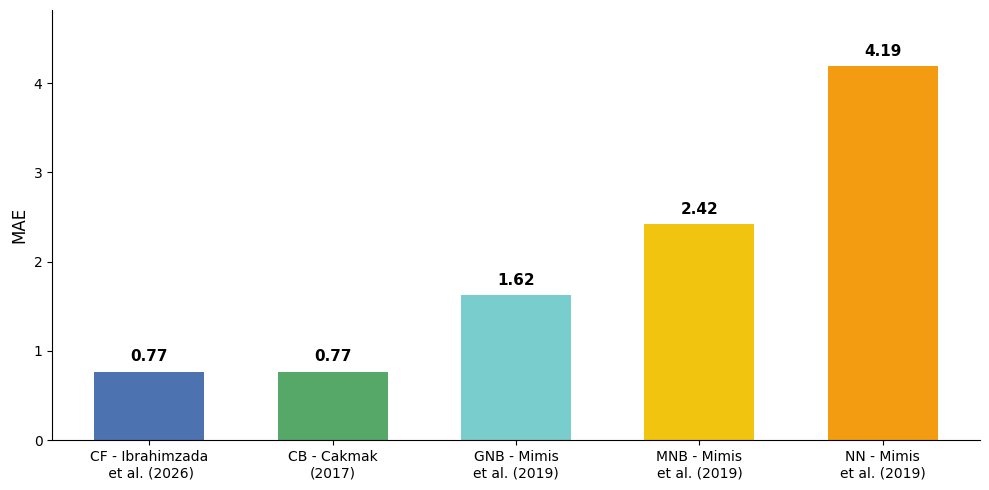

In [59]:
# RMSE Grafiği
plot_final_comparison_styled(nn, nb, cb_2017, cf_2026, metric="RMSE")

# MAE Grafiği (Eğer dosyalarda MAE verisi varsa)
plot_final_comparison_styled(nn, nb, cb_2017, cf_2026, metric="MAE")

# sota subset (no fallback) sonuclari

Grafik kaydedildi: ./SOTA_Comparison_RMSE_Styled.eps


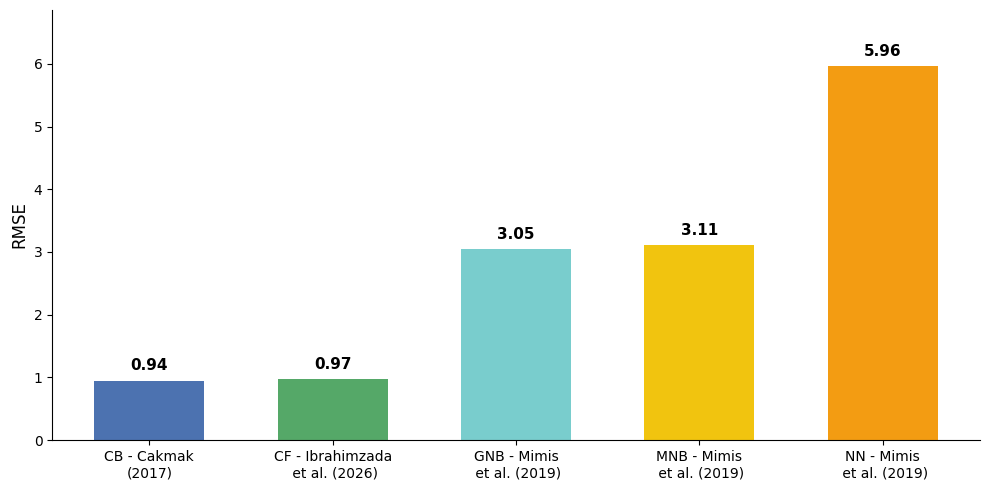

Grafik kaydedildi: ./SOTA_Comparison_MAE_Styled.eps


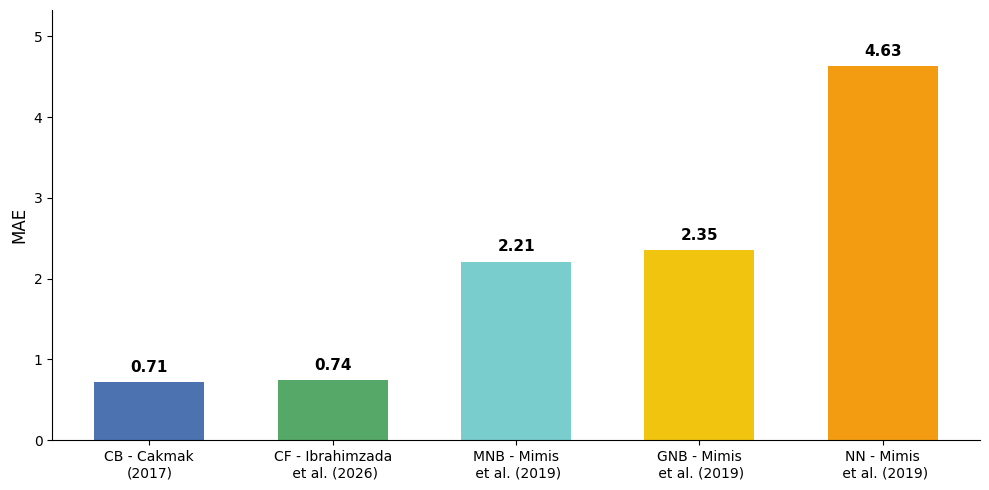

In [62]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# --- AYARLAR ---
RESULTS_DIR = "../results/"

# JSON Dosyası -> Grafikte Görünecek Etiket
# (Satır atlatmak için \n kullanıyoruz)
model_map = {
    "subset_fallback_results_for_cf_student_based.json": "CF - Ibrahimzada\n et al. (2026)",
    "results_2017_subset.json":       "CB - Cakmak\n(2017)",
    "results_gnb_subset.json":        "GNB - Mimis\n et al. (2019)",
    "results_mnb_subset.json":        "MNB - Mimis\n et al. (2019)",
    "results_nn_subset.json":         "NN - Mimis\n et al. (2019)"
}

# Senin stilindeki renkler (Sıralamadan bağımsız modele sabit renk atamak istersen burayı kullan)
# Veya senin kodundaki gibi sıralamaya göre otomatik renk atayabiliriz.
# Şimdilik senin kodundaki renk paletini kullanıyorum:
color_palette = ['#4C72B0', '#55A868', '#79cdcd', '#F1C40F', '#F39C12', '#E74C3C']

def load_results():
    data = []
    for filename, display_name in model_map.items():
        filepath = os.path.join(RESULTS_DIR, filename)
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                res = json.load(f)
                data.append({
                    "Model": display_name,
                    "RMSE": res.get("RMSE", 0),
                    "MAE": res.get("MAE", 0)
                })
        else:
            print(f"UYARI: {filename} bulunamadı!")
    return data

def plot_sota_styled(data, metric="RMSE"):
    # 1. Veriyi Sırala (Küçükten Büyüğe)
    # zip ile veriyi eşleştirip sıralıyoruz
    sorted_data = sorted(data, key=lambda x: x[metric])
    
    # Sıralanmış listeleri ayır
    labels_sorted = [d["Model"] for d in sorted_data]
    values_sorted = [d[metric] for d in sorted_data]
    
    # Renkleri Belirle (Proposed model her zaman farklı renk olsun dersen buraya if koyabiliriz)
    # Şimdilik senin paletinden sırasıyla renk alıyoruz (En iyi sonuç -> İlk renk)
    # Veya model bazlı sabit renk için:
    # colors_sorted = [colors_map.get(lbl, '#333333') for lbl in labels_sorted]
    
    # Senin stilindeki gibi soldan sağa renk paleti:
    current_colors = color_palette[:len(values_sorted)]
    
    x = np.arange(len(labels_sorted))
    
    # 2. Çizim Başlat
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Barları Çiz
    bars = ax.bar(x, values_sorted, color=current_colors, width=0.6)
    
    # 3. Değerleri Yaz (Annotation)
    # Y ekseninin max değerine göre ofset (boşluk) ayarla
    max_val = max(values_sorted) if values_sorted else 1
    offset = max_val * 0.02 # %2 boşluk
    
    for i, val in enumerate(values_sorted):
        ax.text(
            x[i], 
            val + offset, 
            f"{val:.2f}", # 2 hane hassasiyet (SOTA için iyidir)
            ha='center', va='bottom', 
            fontsize=11, fontweight='bold', color='black'
        )
    
    # 4. Eksen ve Stil Ayarları
    ax.set_ylabel(f"{metric}", fontsize=12)
    
    # Y eksenini biraz yukarıdan bitir ki text sığsın
    ax.set_ylim(0, max_val * 1.15) 
    
    # X Eksen Etiketleri
    ax.set_xticks(x)
    ax.set_xticklabels(labels_sorted, rotation=0, ha='center', fontsize=10)
    
    # Sadece Y ekseninde Grid olsun mu? (Senin stilinde yoktu ama değer okumayı kolaylaştırır)
    # ax.grid(axis='y', linestyle='--', alpha=0.3) 
    
    # Spines (Çerçeveler) - Senin stilindeki gibi üst ve sağı kaldır
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Başlık (Opsiyonel - Makalede genelde caption olur, grafik başlığı olmaz)
    # ax.set_title(...) 
    
    plt.tight_layout()
    
    # Kaydet
    filename = f"./SOTA_Comparison_{metric}_Styled.eps"
    # plt.savefig(filename, format="eps", bbox_inches='tight')
    print(f"Grafik kaydedildi: {filename}")
    plt.show()

# --- ÇALIŞTIR ---
results_data = load_results()

if results_data:
    plot_sota_styled(results_data, metric="RMSE")
    plot_sota_styled(results_data, metric="MAE")
else:
    print("Veri yok.")